In [1]:
import gymnasium as gym
import torch
import torch.optim as optim
import numpy as np
import time
import matplotlib.pyplot as plt

import my_package
from my_package import DQN, ReplayBuffer, select_action, optimize_model, eps_decay, soft_update

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

gamma = 0.99
alpha = 0.0001

eps_max = 1.0
eps_min = 0.1
exploration_fraction = 0.8

hidden_layer_dim = 256
target_soft_update = True
tau = 0.001

buffer_size = 100000
batch_size = 256
max_episodes = 300
data_window = 50

env_name = 'ShipQuest-v5'
Options = {
    'generate_random_ship':             True,
    'workspace_safe_distance':          2,
    'n_actions' :                       7,
    'init_pose':                        None,
    'agent_radius':                     0.1,
    'frontal_safe_distance':            0.25,
    'lidar_params':                     {'n_beams': 10, 'max_range': 1.0, 'FoV': np.pi/2},
    'draw_lidar':                       False,
    'max_steps':                        2000
}	

In [7]:
env = gym.make(env_name, Options=Options)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

""" Init neural networks """
policy_net = DQN(
    state_dim=state_dim,
    action_dim=action_dim,
    device=device,
    hidden_dim=hidden_layer_dim,
)

target_net = DQN(
    state_dim=state_dim,
    action_dim=action_dim,
    device=device,
    hidden_dim=hidden_layer_dim,
)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=alpha)

""" Init buffer """
buffer = ReplayBuffer(capacity=buffer_size)

""" Data collect variables """
total_rewards = np.zeros(max_episodes)
eps_history = np.zeros(max_episodes)
len_episodes = np.zeros(max_episodes)
# loss_history = []
reward_collected_per_ep = np.zeros(max_episodes)
coverage_per_ep = np.zeros(max_episodes)

start_time = time.time()

for episode in range(max_episodes):
    state, info = env.reset()
    done = False
    epsilon = eps_decay(episode, max_episodes, eps_min, eps_max, exploration_fraction, 'linear')
    eps_history[episode] = epsilon
    
    while not done:
        action = select_action(state, policy_net, epsilon, action_dim)
        next_state, reward, terminated, truncated, info = env.step(action)
        buffer.push(state, action, reward, next_state, terminated)
        done = terminated or truncated

        # Ottimizzo policy net e soft update target net
        if len(buffer) > batch_size:
            optimize_model(policy_net, target_net, buffer, optimizer, batch_size, gamma, debug=False)
            if target_soft_update:
                soft_update(policy_net, target_net, tau)
            # loss_history.append(loss.cpu().detach().numpy())
            # loss_history.append(loss.item())

        total_rewards[episode] += reward
        len_episodes[episode] += 1
        state = next_state

    coverage_per_ep[episode] = info['coverage']
    
    if episode % data_window == 0 and episode != 0:
        ma_reward = np.mean(total_rewards[episode-data_window:episode])
        ma_coverage = np.mean(coverage_per_ep[episode-data_window:episode])
        # ma_loss = np.mean(loss_history[-data_window:])
        # print(f"Ep {episode}/{max_episodes}, MA Reward: {ma_reward:.2f}, MA loss: {ma_loss:.4f}, Eps: {epsilon:.2f}")
        print(f"Ep {episode}/{max_episodes}, MA Reward: {ma_reward:.2f}, MA Coverage: {ma_coverage:.1f} % , Eps: {epsilon:.2f}")

env.close()

total_time_seconds = time.time() - start_time
hours = int(total_time_seconds // 3600)
minutes = int((total_time_seconds % 3600) // 60)
seconds = int(total_time_seconds % 60)
print(f"Training finito in: {hours} ore {minutes} minuti e {seconds} secondi")

Ep 50/300, MA Reward: -28.25, MA Coverage: 3.7 % , Eps: 0.79
Ep 100/300, MA Reward: -22.32, MA Coverage: 1.7 % , Eps: 0.58
Ep 150/300, MA Reward: -31.03, MA Coverage: 0.6 % , Eps: 0.38
Ep 200/300, MA Reward: -37.60, MA Coverage: 9.8 % , Eps: 0.17
Ep 250/300, MA Reward: -38.11, MA Coverage: 7.6 % , Eps: 0.10
Training finito in: 0 ore 22 minuti e 7 secondi


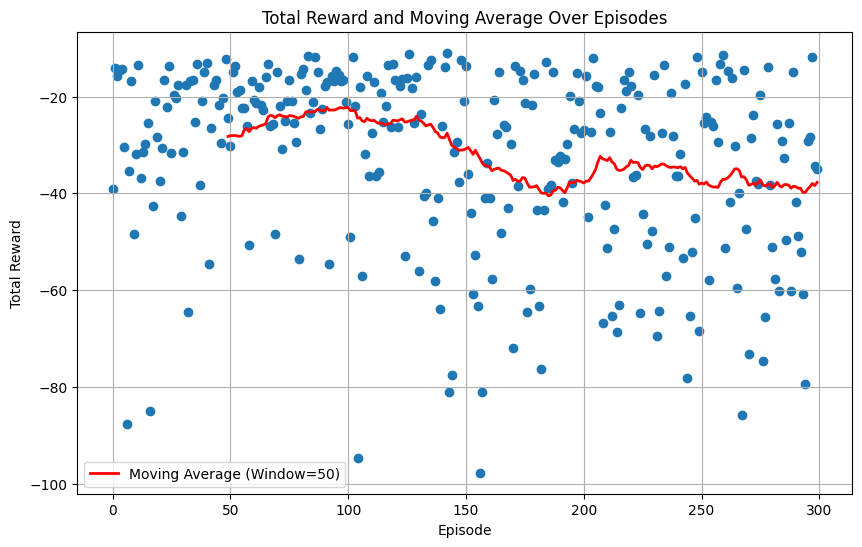

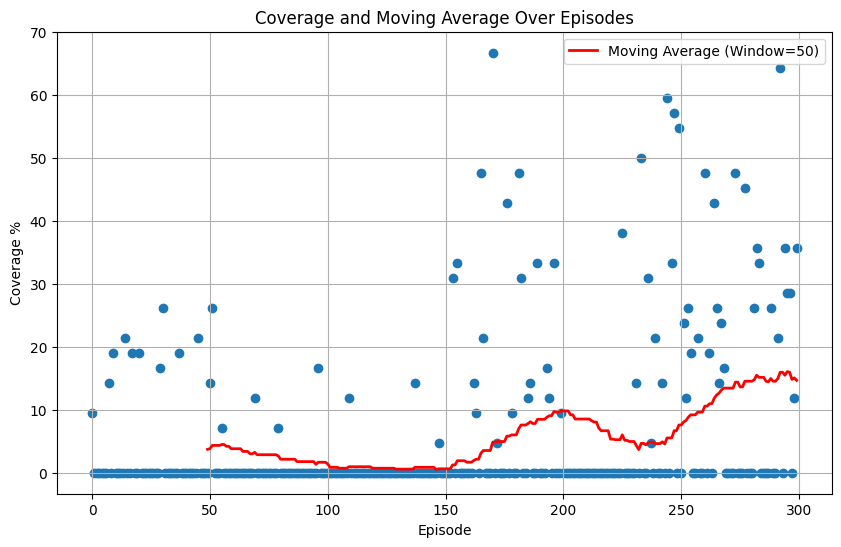

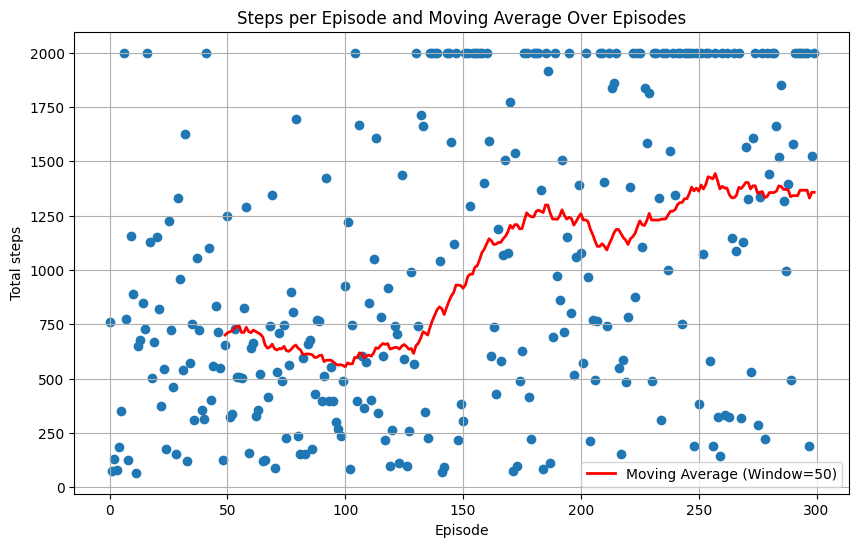

In [8]:
""" Plot rewards """
window_size = 50
ma_reward = np.convolve(total_rewards, np.ones(window_size) / window_size, mode='valid')
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(total_rewards)), total_rewards)
plt.plot(np.arange(window_size - 1, len(total_rewards)), ma_reward, color='red', label=f'Moving Average (Window={window_size})', linewidth=2)
plt.title('Total Reward and Moving Average Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.grid(True)
plt.show()

""" Plot coverage """
window_size = 50
ma_coverage = np.convolve(coverage_per_ep, np.ones(window_size) / window_size, mode='valid')
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(coverage_per_ep)), coverage_per_ep)
plt.plot(np.arange(window_size - 1, len(coverage_per_ep)), ma_coverage, color='red', label=f'Moving Average (Window={window_size})', linewidth=2)
plt.title('Coverage and Moving Average Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Coverage %')
plt.legend()
plt.grid(True)
plt.show()

""" Plot episode duration """
window_size = 50
ma_steps = np.convolve(len_episodes, np.ones(window_size) / window_size, mode='valid')
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(len_episodes)), len_episodes)
plt.plot(np.arange(window_size - 1, max_episodes), ma_steps, color='red', label=f'Moving Average (Window={window_size})', linewidth=2)
plt.title('Steps per Episode and Moving Average Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Total steps')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
env = gym.make(env_name, Options=Options, render_mode='human')

for ep in range(5):
    state, info = env.reset()
    done = False
    total_reward = 0
    while not done:
        action = select_action(state, policy_net, 0, action_dim)
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        state = next_state
        total_reward += reward

    print('total reward: ' + str(total_reward))
env.close()

total reward: -13.47999999999997
total reward: -47.440000000000396
total reward: -20.679999999999858
total reward: -21.509999999999856
total reward: -22.709999999999823


In [ ]:
checkpoint = {
    'gamma' : gamma,
    'alpha' : alpha,
    'eps_max' : eps_max,
    'eps_min' : eps_min,
    'exploration_fraction' : exploration_fraction,
    'state_dim': state_dim,
    'action_dim': action_dim,
    'hidden_layer_dim' : hidden_layer_dim,
    'target_soft_update' : target_soft_update,
    'tau' : tau,
    'buffer_size' : buffer_size,
    'batch_size' : batch_size,
    'max_episodes' : max_episodes,
    'model_state_dict': policy_net.state_dict(),
    'total_rewards': total_rewards,
    'len_episodes' : len_episodes,
    'coverage_per_ep': coverage_per_ep,
    'Options' : Options,
    'env_name': env_name
}

path = "ShipQuest-v5_Data/model_with_data_" + env_name + "_" + str(max_episodes) + "_ep.pth"
torch.save(checkpoint, path)